In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

* Create a Kalman Filter Class from scratch

In [5]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # Initialize
        n = len(x0)
        self.states = np.empty((n,N))
        self.obs = np.empty((2,N))
        self.states[:,0] = x0
        self.obs[:,0] = x0[:2]
        
        # Run Kalman system
        for i in range(1,N):
            state_noise = np.random.multivariate_normal(np.zeros(4),self.Q)
            self.states[:,i] = self.F @ x0 + self.u + state_noise
            obs_noise = np.random.multivariate_normal(np.zeros(2), self.R)
            self.obs[:,i] = self.H @ x0 + obs_noise
            
            # Update the previous step
            x0 = self.states[:,i]
            
        return self.states, self.obs
            
            
    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        norms: list of floats of length N
            Gives the norm of the error matrix for each estimate.
        """
        # Initialize
        n = len(x0)
        N = z.shape[1]
        out = np.zeros((n,N))
        out[:,0] = x0
        norms = [norm(P0)]
        
        
        # Apply the predict/update steps of the kalman filter
        for i in range(1,N):
            # Predict
            out[:,i] = self.F @ out[:,i-1] + self.u # Correct way to calculate x_k|k-1?
            P1 = self.F @ P0 @ self.F.T + self.Q
            norms.append(norm(P1)) # Calculate norm here or in update?
            
            # Update
            y = z[:,i] - self.H @ out[:,i]
            S = self.H @ P1 @ self.H.T + self.R
            K = P1 @ self.H.T @ inv(S)
            out[:,i] = out[:,i] + K @ y # Correct way to update x_k|k?
            P0 = (np.eye(n) - K @ self.H) @ P1
            
        return out, norms
            
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # Initialize
        n = len(x)
        out = np.zeros((n,k))  
        out[:,0] = x
        
        # Predict using only initial state
        for i in range(1,k):
            out[:,i] = self.F@out[:,i-1] + self.u
            
        return out
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        n = len(x)
        out = np.zeros((n,k))
        out[:,0] = x
        
        # Reverse the system
        for i in range(1,k):
            out[:,i] = inv(self.F) @ (out[:,i-1] - self.u)
            
        return out

In [6]:
def instantiate():
    """ 
    Instantiate and retrun a KalmanFilter object with the transition and observation 
    models F and H, along with the control vector u, corresponding to the 
    projectile. Assume that the noise covariances are given by
    Q = 0.1 · I4
    R = 5000 · I2.
    
    Return the KalmanFilter Object
    """
    # Initialize
    Q = 0.1 * np.identity(4)
    R = 5000 * np.identity(2)
    F = np.array([[1, 0, 0.1, 0],
                  [0, 1, 0, 0.1],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    
    u = np.array([0,0,0,-0.98])
    #noise = np.random.multivariate_normal(np.array([0,0]),R)
    H = np.array([[1,0,0,0],
                  [0,1,0,0]])
    
    # Instantiate a KalmanFilter object
    kalman = KalmanFilter(F,Q,H,R,u)
    return kalman

In [37]:
def state_estimates(plot=True):
    """
    Calculate an initial state estimate xb200. Using the initial state estimate, 
    P200 and your Kalman Filter, compute the next 600 state estimates. 
    Plot these state estimates as a smooth green
    curve together with the radar observations (as red dots) and the entire
    true state sequence (as blue curve).
    """
    # Initialize
    kalman = instantiate()
    x0 = np.array([0,0,300,600])
    N = 1250
    states, obs = kalman.evolve(x0,N)
    Q = kalman.Q
    
    # Calculate initial state and covariance matrix P200
    x200 = obs[:,200]
    x_vel = np.abs(np.mean(np.diff(states[2:,200:209])[0]))
    y_vel = np.abs(np.mean(np.diff(states[2:,200:209])[1]))
    initial_state = np.array([x200[0],x200[1],x_vel,y_vel])
    P200 = 10e6 * Q
    
    # Calculate next 600 state estimates
    z = obs[:,200:800]
    state_estimates, norms = kalman.estimate(initial_state, P200, z, return_norms=True)
    
    # Plot
    if plot == True:
        fig, ax = plt.subplots(1,2,figsize=(8,5))
        ax[0].plot(states[0],states[1],color='blue')
        ax[0].plot(state_estimates[0,:],state_estimates[1,:],color='green')
        ax[0].scatter(obs[0,200:800],obs[1,200:800],color='red',s=1)
        ax[0].legend(['State Estimates','True States','Observations'])
        ax[1].plot(states[0],states[1],color='blue')
        ax[1].plot(state_estimates[0,:],state_estimates[1,:],color='green')
        ax[1].scatter(obs[0,200:800],obs[1,200:800],color='red',s=1)
        ax[1].set_xlim([7400,9200])
        ax[1].set_ylim([11800,13600])
        ax[1].legend(['State Estimates','True States','Observations'])
        plt.suptitle("Estimate States 200-600")
        plt.tight_layout()
        plt.show()
        
    else:
        return state_estimates
    
    

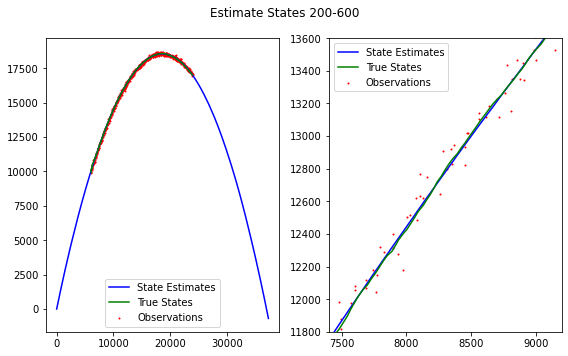

In [38]:
state_estimates()

In [35]:
def future_states():
    """
    Using the final state estimate xb800 that you obtained in Problem 5, 
    predict the future states of the projectile until it hits the ground. 
    Plot the actual state sequence together with the predicted state sequence 
    (as a yellow curve), and observe how near the prediction is to the actual 
    point of impact. Y
    """   
    kalman = instantiate()
    x0 = np.array([0,0,300,600])
    N = 1250
    states, obs = kalman.evolve(x0,N)
    x800 = state_estimates(plot=False)[:,-1]
    k = 450
    
    predict_states = kalman.predict(states[:,800],k)
    
    # Plot
    fig, ax = plt.subplots(1,2,figsize=(8,5))
    ax[0].plot(states[0],states[1],color='blue')
    ax[0].plot(predict_states[0,:],predict_states[1,:],color='gold')
    ax[0].set_ylim([0,20000])
    ax[0].legend(['True States','Predicted'])
    ax[1].plot(states[0,:],states[1,:],color='blue')
    ax[1].plot(predict_states[0,:],predict_states[1,:],color='gold')
    ax[1].set_xlim([34000, 38500])
    ax[1].set_ylim([0,100])
    ax[1].legend(['True States','Predicted'])
    plt.suptitle('Estimation of Final Position')
    plt.tight_layout()
    plt.show()

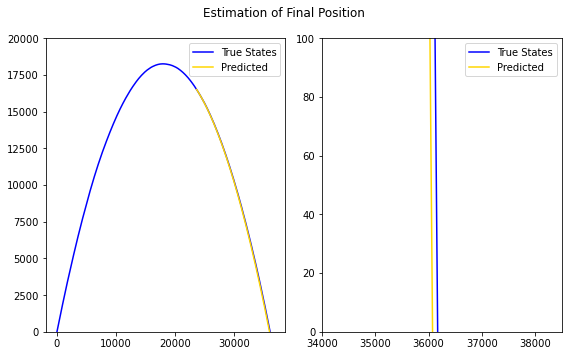

In [36]:
future_states()

In [31]:
def past_states():
    """
    Using your state estimate xb250, predict the point of origin of the 
    projectile along with all states leading up to time step 250. 
    Plot these predicted states (in cyan) together with the original state 
    sequence. Repeat the prediction starting with xb600. 
    """
    kalman = instantiate()
    x0 = np.array([0,0,300,600])
    N = 1250
    states, obs = kalman.evolve(x0,N)
    x800 = state_estimates(plot=False)[:,-1]
    k1 = 250 + 50
    k2 = 600 + 50
    
    predict250 = kalman.rewind(states[:,250],k1)
    predict600 = kalman.rewind(states[:,600],k2)
    
    # Plot
    fig, ax = plt.subplots(2,2,figsize=(8,7))
    ax[0,0].plot(states[0],states[1],color='blue')
    ax[0,0].plot(predict250[0,:],predict250[1,:],color='gold')
    ax[0,0].set_ylim([0,20000])
    ax[0,0].set(ylabel='Predictions start at 250')
    ax[0,0].legend(['True States','Predicted'])
    ax[0,1].plot(states[0],states[1],color='blue')
    ax[0,1].plot(predict250[0,:],predict250[1,:],color='gold')
    ax[0,1].set_xlim([-400, 300])
    ax[0,1].set_ylim([0,100])
    ax[0,1].legend(['True States','Predicted'])
    ax[1,0].plot(states[0,:],states[1,:],color='blue')
    ax[1,0].plot(predict600[0,:],predict600[1,:],color='gold')
    ax[1,0].set_ylim([0,20000])
    ax[1,0].set(ylabel='Predictions start at 600')
    ax[1,0].legend(['True States','Predicted'])
    ax[1,1].plot(states[0],states[1],color='blue')
    ax[1,1].plot(predict600[0,:],predict600[1,:],color='gold')
    ax[1,1].set_xlim([-500, 550])
    ax[1,1].set_ylim([0,100])
    ax[1,1].legend(['True States','Predicted'])
    plt.suptitle('Estimation of Origin')
    plt.tight_layout()
    plt.show()

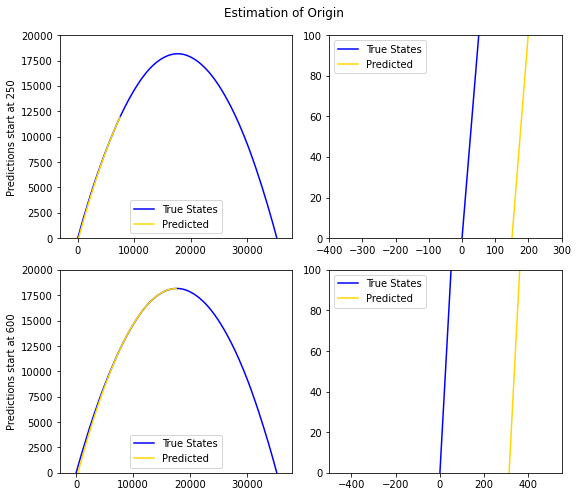

In [32]:
past_states()